In [7]:

import os
import sys
import importlib
import copy
from collections import defaultdict
sys.path.insert(0, '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc')

from tools_pattern import get_eucledean_dist

# script_n = os.path.basename(__file__).split('.')[0]
script_n = 'distribution_123share_210512_clustering3'

import my_plot
importlib.reload(my_plot)
from my_plot import MyPlotData, my_box_plot

def to_ng_coord(coord):
    return (
        int(coord[0]/4),
        int(coord[1]/4),
        int(coord[2]/40),
        )

import compress_pickle

# input_graph = compress_pickle.load('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/'\
#                                    'mf_grc_model/input_graph_201114_restricted_z.gz')
fname = ('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/'\
#                                    'mf_grc_model/input_graph_210407_xlim_90_140_zlim_0.0_44.0.gz')
                                   'mf_grc_model/input_graph_210407_all.gz')
input_graph = compress_pickle.load(fname)

# z_min = 19800
# z_max = 29800
z_min = 19800-15000
z_max = 29800+15000
# GrCs are fully reconstructed and proofread from 90k to 150k
x_min = 90*1000*4
x_max = 140*1000*4
# radius = 200

n_randoms = 5
replication_hist2 = defaultdict(int)
grc_ids = set()
mf_ids = set()
replicated_2shares = defaultdict(int)
grc_rosettes = {}
pair_hist = defaultdict(int)

def get_prob(in_graph, unique_count=False, count_within_box=True, return_counted=False):
    n_common_pairs = 0
    processed = set()
    total_n_pairs = 0
    hist = defaultdict(int)
    n = 0
    counted_grcs = 0
    for grc_i_id in in_graph.grcs:
        n += 1
        grc_i = in_graph.grcs[grc_i_id]
        x, y, z = grc_i.soma_loc
        if count_within_box:
            if x < x_min or x > x_max:
                continue
            if z < z_min or z > z_max:
                continue
        counted_grcs += 1
        grc_ids.add(grc_i_id)
        rosettes_i = set([mf[0] for mf in grc_i.edges])
        grc_rosettes[grc_i_id] = rosettes_i
        for r in rosettes_i:
            mf_ids.add(r)
        for grc_j_id in in_graph.grcs:
            if grc_i_id == grc_j_id:
                continue
            if unique_count and (grc_i_id, grc_j_id) in processed:
                continue
            processed.add((grc_i_id, grc_j_id))
            processed.add((grc_j_id, grc_i_id))
            grc_j = in_graph.grcs[grc_j_id]
            x, y, z = grc_j.soma_loc
#             if count_within_box:
#                 if x < x_min or x > x_max:
#                     continue
#                 if z < z_min or z > z_max:
#                     continue
            common_rosettes = set([mf[0] for mf in grc_j.edges])
            common_rosettes = common_rosettes & rosettes_i
            hist[len(common_rosettes)] += 1
            if len(common_rosettes) == 2:
                replication_hist2[grc_i_id] += 1
                common_rosettes = tuple(sorted(list(common_rosettes)))
                replicated_2shares[common_rosettes] += 1
            if len(common_rosettes) == 2:
                pair_hist[(grc_i_id, grc_j_id)] = .7
                pair_hist[(grc_j_id, grc_i_id)] = .7
            elif len(common_rosettes) == 3:
                pair_hist[(grc_i_id, grc_j_id)] = .9
                pair_hist[(grc_j_id, grc_i_id)] = .9
    for k in hist:
        # fix 0 datapoint plots
        if hist[k] == 0:
            hist[k] = 1
    if return_counted:
        return hist, counted_grcs
    else:
        return hist


# input_graph.randomize_graph_by_grc2(
# #     constant_dendrite_length='depth',
#     mf_dist_margin=5000,
#     seed=1,
# )

input_graph.edge_probabilities_by_pos = None
input_graph.shuffle_edges(
    seed=1,
#     mf_dist_margin=10000,
    )

    
input_observed = copy.deepcopy(input_graph)
hist_data, n_grcs = get_prob(input_observed, count_within_box=True, return_counted=True)

print(n_grcs)
print(hist_data)
# n_grcs = len(input_graph.grcs)

1375
defaultdict(<class 'int'>, {0: 3337827, 1: 93938, 2: 2916, 3: 69})


In [2]:
pair_hist
('grc_1143', 'grc_1371') in pair_hist

False

In [8]:

grc_ids_list = list(grc_ids)
grc_data_array = []

for grc_i in grc_ids_list:
    tmp = []
    for grc_j in grc_ids_list:
        if grc_i == grc_j:
            tmp.append(1)
            continue
        comb = (grc_i, grc_j)
        if comb in pair_hist:
            tmp.append(pair_hist[comb])
        else:
            tmp.append(0)
    grc_data_array.append(tmp)



In [5]:
grc_data_array[4]
sum(grc_data_array[4])

5.2

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


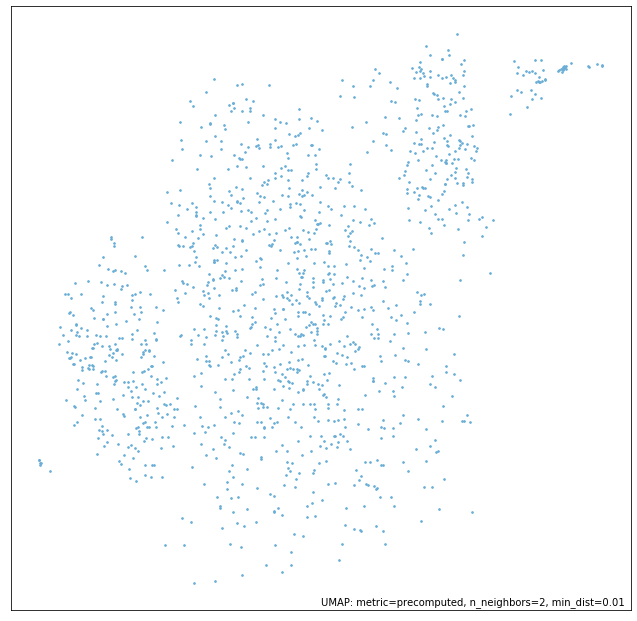

In [9]:
import umap
import umap.plot
mapper = umap.UMAP(
#     random_state=1,
#     n_neighbors=100,
    n_neighbors=2,
    metric='precomputed',
    min_dist=.01,
    ).fit(grc_data_array)
umap.plot.points(mapper)

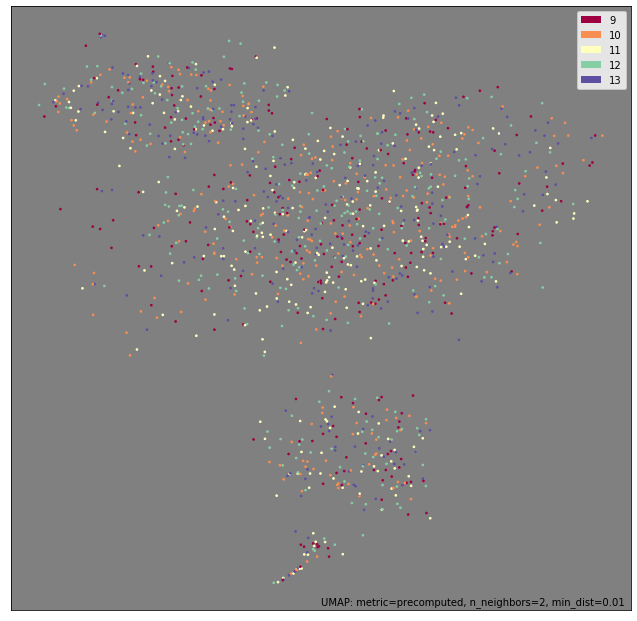

In [5]:
import numpy as np
labels = []
for grc_id in grc_ids_list:
    grc = input_graph.grcs[grc_id]
    x, y, z = grc.soma_loc
    labels.append(int(x/10000/4))
labels = np.array(labels)

umap.plot.points(mapper, labels=labels,
                 background='grey',)

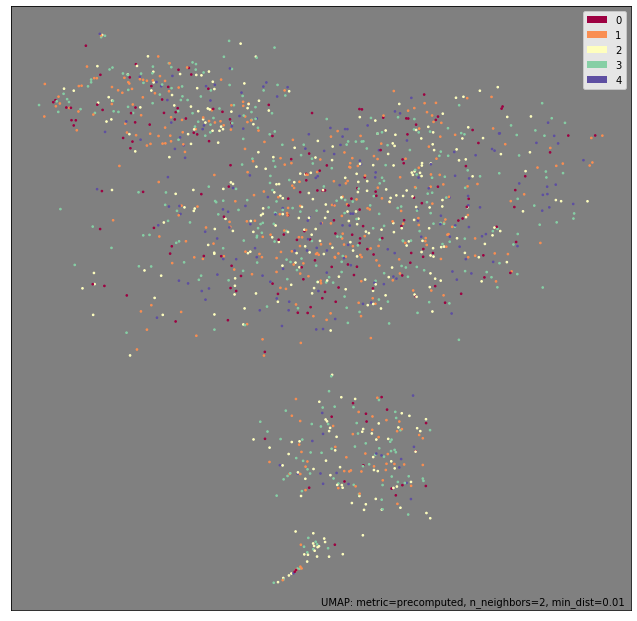

In [6]:
import numpy as np
labels = []
for grc_id in grc_ids_list:
    grc = input_graph.grcs[grc_id]
    x, y, z = grc.soma_loc
    labels.append(int(z/10000))
labels = np.array(labels)

umap.plot.points(mapper, labels=labels,
#                  theme='viridis',
                 background='grey',
                )